## <span style="color:green"><h1><center>DEM Accessing using a Shapefile</center></h1></span>
<center>Prepared by <br>
    <b>Jibin Joseph and Venkatesh Merwade</b><br> 
Lyles School of Civil Engineering, Purdue University<br>
joseph57@purdue.edu, vmerwade@purdue.edu<br>
<b><br>
    FAIR Science in Water Resources</b><br></center>


## <span style="color:green">Objective</span>
<p style='text-align: justify;'>We will download DEM raster files from USGS National Elevation Dataset using the extents of watershed shapefile accessed using USGS site number. Later, the DEM raster files will be plotted along with watershed boundary.</p> 

## <span style="color:green"> Data Source </span>

<p style='text-align: justify;'>USGS 1/3 arc second DEM</p>

## <span style="color:green">Overview of steps </span>
<ol type="1">
    <span style="color:red"><li>Using USGS Station Number, get the shapefile for a  basin (watershed) and it extents</li></span>
    <span style="color:red"><li>Download the DEM from USGS-Amazon Web Service</li></span>
     <span style="color:red"><li>Plotting the Unmerged Raster Tiles</li></span>



## <span style="color:green">Import the packages/modules required for this exercise</span>

We need different packages as shown below. It can be either installed using pip method or conda method.


In [1]:
## Import the modules/packages/libraries required
import math
import numpy as np
import os
import matplotlib.pyplot as plt

from pynhd import NLDI
import urllib.request
import progressbar
import rasterio
import rasterio.plot

import geopandas as gpd
from shapely.geometry import Polygon

from datetime import datetime


## <span style="color:green">Step 1a: Input USGS Site, DEM resolution, and create a directory</span> 
<ul>
<li>Input: <span style="color:red">USGS Site</span></li>
<li>Input: <span style="color:red">Desired resolution</span></li>
<li>Create: <span style="color:red">Folder for storing input raster files from USGS AWS</span></li>

In [2]:
## Input the USGS site number to get the shapefile
## E.g. "04180000" has a drainage area of 270 sq mi and can downloaded within 2-3 minutes
## But "03335500" has a drainage area of 7267 sq mi and needs for time and space
## WRITE CODE BELOW
#site_id ='14183000'
site_id='04180000'
#"09037500" #WILLIAMS FORK NEAR PARSHALL, CO
#07103700	FOUNTAIN CREEK NEAR COLORADO SPRINGS, CO.
#09064500	HOMESTAKE CREEK NEAR RED CLIFF, CO.
#09241000 ELK RIVER AT CLARK, CO.	CO

#site_id ='03203000'# GUYANDOTTE RIVER AT MAN, WV
#site_id ='03326500'# MISSISSINEWA RIVER AT MARION, IN
#site_id='14183000' # NORTH SANTIAM RIVER AT MEHAMA, OR
#site_id='12189500' # SAUK RIVER NEAR SAUK, WA

## Resolution of required DEM
## USGS-AWS has different options like 1/3 arc second (code = 13), 1/9 arc second (code = 19; currently unavailable)
## WRITE CODE BELOW
resolution='13'  

## Define a function for making a directory depending on whether is exists or not.
## We are creating a function so that it can be used later for creating three folders in the later modules
def check_create_path_func(path):
    isExist = os.path.exists(path)
    if not isExist:
        # Create a new directory because it does not exist
        os.makedirs(path)
        print(f"The new directory \033[1m'{path}'\033[0m is created!")
    else:
        print(f"The new directory \033[1m'{path}'\033[0m is not created as it already exists!")
        
## Create the a folder for storing DEMs using the earlier defined function
## WRITE CODE BELOW
#folder_input=f'/glade/derecho/scratch/jjoseph/dem_analysis/input_{site_id}'
folder_input=f'./data_{site_id}'
dem_files_store=f'{folder_input}/raw_{site_id}'
check_create_path_func(folder_input)
check_create_path_func(dem_files_store)

The new directory './data_04180000' is created!
The new directory './data_04180000/raw_04180000' is created!


## <span style="color:green">Step 1b: Input USGS Site and get the basin</span> 

<ul>
<li>Input: <span style="color:red">Get a input station</span></li>
<li>Output: <span style="color:red">Find out the basin</span></li>
<li>Output: <span style="color:red">Save the basin file as shapefile</span></li>
    

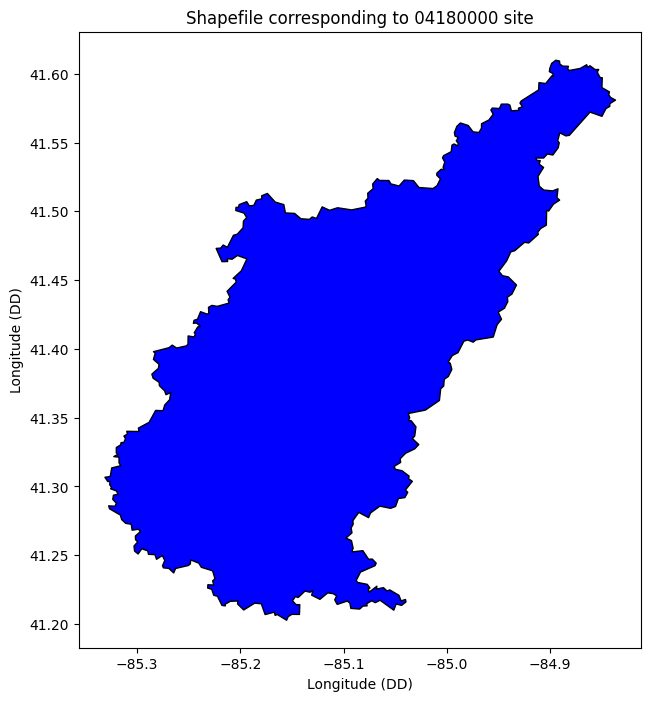

In [3]:
## Get the watershed using USGS station number using pynhd module
## WRITE THE CODE BELOW
watershed = NLDI().get_basins(site_id)

## Plot the watershed
## DD indicates latitude/ longitude degrees is followed by immediately followed by decimal
ax = watershed.plot(facecolor="b", 
                    edgecolor="k", 
                    figsize=(8, 8))
plt.title(f"Shapefile corresponding to {site_id} site")
plt.xlabel("Longitude (DD)")
plt.ylabel("Longitude (DD)")

## Saving the watershed file as a shapefile at desired location
## WRITE THE CODE BELOW
shapefile_fileloc_filename=f'{folder_input}/shape_{site_id}.shp'
watershed.to_file(filename=shapefile_fileloc_filename,
                  driver= 'ESRI Shapefile',
                  mode='w')

## <span style="color:green">Creating an Inset Map</span> 

<ul>
<li>Input: <span style="color:red">Get a input station</span></li>
<li>Output: <span style="color:red">Find out the basin</span></li>
<li>Output: <span style="color:red">Save the basin file as shapefile</span></li>
    

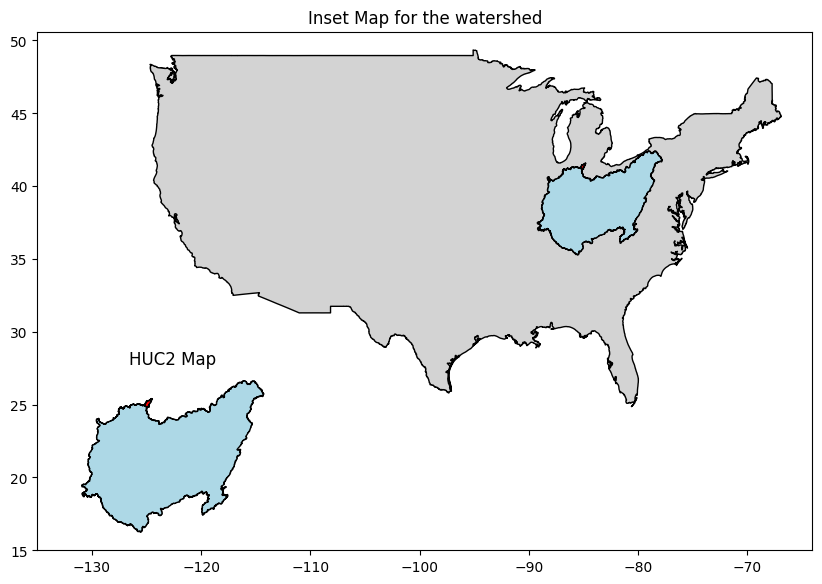

In [11]:
# Load shapefiles
watershed_map=gpd.read_file(f'{folder_input}/shape_{site_id}.shp')
us_map = gpd.read_file("/home/joseph57-40purdue-2eedu/shared/data_dem_access/cb_2018_us_conus_5m.shp")
huc_map = gpd.read_file("/home/joseph57-40purdue-2eedu/shared/data_dem_access/HUC2_modified6.shp")
huc_map_proj=huc_map.to_crs(watershed_map.crs)
watershed_with_huc = gpd.sjoin(watershed_map, huc_map_proj, 
                               how="left"#, 
                               #predicate='within'
                              )
specific_huc_map = watershed_with_huc[watershed_with_huc['identifier'] == f'USGS-{site_id}']['NAME'].iloc[0]
selected_huc2=huc_map_proj[huc_map_proj['NAME']==specific_huc_map]
## Plot the main map (US map)
fig, ax = plt.subplots(figsize=(10, 10))
us_map.to_crs(watershed_map.crs).plot(ax=ax, color='lightgrey', edgecolor='black')
selected_huc2.plot(ax=ax, color='lightblue', edgecolor='black')
watershed_map.plot(ax=ax, color='red', edgecolor='black')
ax.set_xlim(xmin=-135)
ax.set_ylim(ymin=15)
ax.set_title('Inset Map for the watershed')

## Plot the inset HUC2 (HUC2 map)
inset_ax = fig.add_axes([0.16, 0.23, 0.2, 0.2])  # [left, bottom, width, height]
selected_huc2.plot(ax=inset_ax, color='lightblue', edgecolor='black')
watershed_map.plot(ax=inset_ax, color='red', edgecolor='black')
inset_ax.set_title('HUC2 Map')
# Remove axes numbers for the inset map
inset_ax.axis('off')
plt.show()

In [10]:
!ls /home/shared

ls: cannot access '/home/shared': No such file or directory


## <span style="color:green">Step 2: Get the extents for downloading DEM</span>

<ul>
<li> Extents of the basin (watershed) is obtained using .total_bounds </li>
<li> Then we will find the bounding extents using math floor and ceil function </li>
    

In [33]:
## Get the min and max of latitude and longitude (or easting and northing)
extents_basin=watershed.total_bounds

## N or S and W or E may become a problem
print(f'Left Bounding Longtitude is {extents_basin[0]:.3f}\u00b0 or {abs(extents_basin[0]):.3f}\u00b0 W')
print(f'Right Bounding Longtitude is {extents_basin[2]:.3f}\u00b0 or {abs(extents_basin[2]):.3f}\u00b0 W')
print(f'Bottom Bounding Latitude is {extents_basin[1]:.3f}\u00b0 or {abs(extents_basin[1]):.3f}\u00b0 N')
print(f'Top Bounding Latitude is {extents_basin[3]:.3f}\u00b0 or {abs(extents_basin[3]):.3f}\u00b0 N')

Left Bounding Longtitude is -85.332° or 85.332° W
Right Bounding Longtitude is -84.837° or 84.837° W
Bottom Bounding Latitude is 41.203° or 41.203° N
Top Bounding Latitude is 41.610° or 41.610° N


In [34]:
## DEMs are numbered using integer
## Calculate largest integer that equals or not greater than left and bottom bounds
## WRITE THE CODE BELOW
extent_left=abs(math.floor(extents_basin[0]))
extent_right=abs(math.floor(extents_basin[2]))
## You may be tempted to calculate the ceil of right extent
## But, number scheme is such that 84W indicates data from -84 to -83 deg W

## Calculate smallest integer that equals or not less than right and upper bounds
## WRITE THE CODE BELOW
extent_bottom=abs(math.ceil(extents_basin[1]))
extent_top=abs(math.ceil(extents_basin[3]))
## Similarly, you may be tempted to calculate the floor of bottom extent
## But, number scheme is again such that 40N includes data from +39 to +40 deg N 



## <span style="color:green">Step 3: Find DEM tiles which overlap with watershed bondary</span>

<ul>
<li> Create a rectangular boundary file using the extents </li>
<li> Make sure the rectangular boundary file have the same projection as the watershed </li>
<li> If the rectangular boundary file overlaps with the watershed, add the lon and lat pair to a list </li>

In [35]:
## Define a empty list to hold lon and lat pair
overlap_lonlat=[]

## Create a for loop to create a rectangular boundary and see if overlaps with watershed
for lon in (range(extent_right,extent_left+1,1)):
    for lat in (range(extent_bottom,extent_top+1,1)):
        ## Defining in anticlockwise direction
        corner_left_bottom=(-lon,lat-1)
        corner_right_bottom=(-lon+1,lat-1)
        corner_right_top=(-lon+1,lat)
        corner_left_top=(-lon,lat)
        
        # Create a polygon from the coordinates
        rectangular_boundary = Polygon([corner_left_bottom,corner_right_bottom,corner_right_top,corner_left_top])

        # Create a GeoDataFrame
        rectangular_gdf = gpd.GeoDataFrame(geometry=[rectangular_boundary])
        
        # Set the coordinate reference system (CRS) if needed
        # Example: gdf.crs = {'init': 'epsg:4326'}  # WGS84

        rectangular_gdf.crs = watershed.crs

        # Perform the overlay operation to find the intersection
        intersection = gpd.overlay(watershed, rectangular_gdf, how='intersection')

        # Check if there's any intersection
        if not intersection.empty:
            #print("The rectangular polygon overlaps with the shapefile.")
            overlap_lonlat.append((lon,lat))
        #else:
        #    print("The rectangular polygon does not overlap with the shapefile.")       

print("The required lon and lat pairs are: \n",overlap_lonlat)

## Calulate the number of tiles to be downloaded from USGS
num_tiles_download=(((extent_left+1)-extent_right)*((extent_top+1)-extent_bottom))
print(f"\nNumber of tiles required to cover the entire region: {num_tiles_download}")
print(f"Left: {extent_left}, Right: {extent_right}, Bottom: {extent_bottom}, Top: {extent_top}")

print(f"\nNumber of tiles within watershed boundary: {len(overlap_lonlat)}")

The required lon and lat pairs are: 
 [(85, 42), (86, 42)]

Number of tiles required to cover the entire region: 2
Left: 86, Right: 85, Bottom: 42, Top: 42

Number of tiles within watershed boundary: 2


In [36]:
## Create a progress bar for monitoring the download process
class MyProgressBar():
    def __init__(self):
        self.pbar = None

    def __call__(self, block_num, block_size, total_size):
        if not self.pbar:
            self.pbar=progressbar.ProgressBar(maxval=total_size)
            self.pbar.start()

        downloaded = block_num * block_size
        if downloaded < total_size:
            self.pbar.update(downloaded)
        else:
            self.pbar.finish()

## <span style="color:green">Step 4a (sequential download): Downloading the DEM from USGS-Amazon Web Service</span>

<ul>
<li> Create a for loop anf download the DEM covering the shapefile </li>
<li> Save it in a folder </li>

In [37]:
start_time_seq=datetime.now()

current_filenum=1

# Iterate over the locations list and print each pair
for location in overlap_lonlat:
    print("Latitude:", location[1] ,"N ;", ", Longitude:", location[0],"W")

    usgs_filename=f'n{location[1]:02d}w{location[0]:03d}'
    
    print(f'Beginning file download with urllib2 ({current_filenum}/{len(overlap_lonlat)})...')
    url = (f'https://prd-tnm.s3.amazonaws.com/StagedProducts/Elevation/{resolution}/TIFF'
           f'/current/{usgs_filename}/USGS_{resolution}_{usgs_filename}.tif'
          )
            
    ## The r in 'fr' disables backslach escape sequence processing
    local_fileloc_filename=fr'{dem_files_store}/USGS_{resolution}_{usgs_filename}.tif'
    
    ## Retrieve the file using the weblink and local path with file name
    print('Data downloaded from : ')
    print(url)
    ## WRITE THE CODE BELOW
    #urllib.request.urlretrieve(url,local_fileloc_filename) #without progressbar for multiple USGS sites
    urllib.request.urlretrieve(url,local_fileloc_filename,MyProgressBar())
    
    
    print(f'Completed file download ({current_filenum}/{len(overlap_lonlat)})...')
    print(f'*************************************************************************************\n')
    
    current_filenum+=1

end_time_seq=datetime.now()

Latitude: 42 N ; , Longitude: 85 W
Beginning file download with urllib2 (1/2)...
Data downloaded from : 
https://prd-tnm.s3.amazonaws.com/StagedProducts/Elevation/13/TIFF/current/n42w085/USGS_13_n42w085.tif


100% |########################################################################|


Completed file download (1/2)...
*************************************************************************************

Latitude: 42 N ; , Longitude: 86 W
Beginning file download with urllib2 (2/2)...
Data downloaded from : 
https://prd-tnm.s3.amazonaws.com/StagedProducts/Elevation/13/TIFF/current/n42w086/USGS_13_n42w086.tif


Completed file download (2/2)...
*************************************************************************************



## <span style="color:green">Step 4a (threading for faster download): Downloading the DEM from USGS-Amazon Web Service</span>

In [38]:
import threading

def download_dem_file_func(usgs_filename, local_fileloc_filename):
    try:
        #urllib.request.urlretrieve(url, local_fileloc_filename,MyProgressBar())
        print(f'Beginning file download for {usgs_filename}...')
        urllib.request.urlretrieve(f'https://prd-tnm.s3.amazonaws.com/StagedProducts/Elevation/{resolution}/TIFF'
                                   f'/current/{usgs_filename}/USGS_{resolution}_{usgs_filename}.tif',
        local_fileloc_filename)
        print(f"Completed file download and saved to {local_fileloc_filename}")
    except Exception as e_value:
        print(f"Error downloading {url}: {e_value}")

start_time_thread=datetime.now()

## Create empty list and append the names
usgs_file_list=[]
local_fileloc_filename_list=[]
for location in overlap_lonlat:
    usgs_filename=f'n{location[1]:02d}w{location[0]:03d}'
    usgs_file_list.append(f'n{location[1]:02d}w{location[0]:03d}')
    local_fileloc_filename_list.append(fr'{dem_files_store}/USGS_{resolution}_{usgs_filename}.tif')

## Threading for parallel download to reduce time
threads = []
for usgs_file, filename in zip(usgs_file_list, local_fileloc_filename_list):
    #print(url,filename)
    thread = threading.Thread(target=download_dem_file_func,
                              args=(usgs_file, filename))
    thread.start()
    threads.append(thread)

## Wait for all threads to finish to avoid unexpected behavior or incorrect output
for thread in threads:
    thread.join()
end_time_thread=datetime.now()

Beginning file download for n42w085...
Beginning file download for n42w086...
Completed file download and saved to /glade/derecho/scratch/jjoseph/dem_analysis/data_04180000/raw_04180000/USGS_13_n42w086.tif
Completed file download and saved to /glade/derecho/scratch/jjoseph/dem_analysis/data_04180000/raw_04180000/USGS_13_n42w085.tif


## <span style="color:green">Step 4a: Time Comparison</span>

In [39]:
## Time Comparison

print(f'Time taken for sequential downloading: {end_time_seq-start_time_seq}')
print(f'Time taken for parallel downloading: {end_time_thread-start_time_thread}')
print(f'\nEfficiency: {(end_time_seq-start_time_seq)/(end_time_thread-start_time_thread)}')


Time taken for sequential downloading: 0:00:36.561738
Time taken for parallel downloading: 0:00:07.586341

Efficiency: 4.819416633130517


## <span style="color:green">Step 4b: Plotting the downloaded (single/unmerged) DEMs along with watershed shapefile</span>

<ul>
<li> Plot the single or different DEMs using rasterio package </li>
<li> Also, plot the shapefile of the watershed </li>

Text(53.722222222222214, 0.5, 'Longitude (DD)')

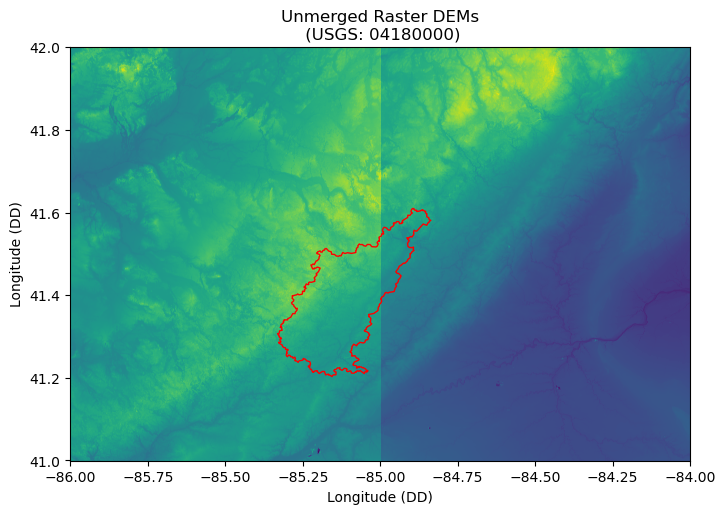

In [40]:
if (len(overlap_lonlat)>1):
    title=f"Unmerged Raster DEMs\n (USGS: {site_id})"
else:
    title=f"Single Raster DEM\n (USGS: {site_id})"
    
fig, ax = plt.subplots(figsize=(8, 8))

for location in overlap_lonlat:
        usgs_filename=f'n{location[1]:02d}w{location[0]:03d}'
        ## WRITE THE CODE BELOW
        local_raster_filename=fr'{dem_files_store}/USGS_{resolution}_{usgs_filename}.tif'
        raster = rasterio.open(local_raster_filename)
        rasterio.plot.show(raster,
                           ax=ax,
                           cmap='viridis')
        #print(f'lat: {lat},lon: {lon},file:{local_fileloc_filename}')
watershed.plot(ax=ax, 
           facecolor='none', 
           edgecolor='red')
plt.title(title)
plt.xlabel("Longitude (DD)")
plt.ylabel("Longitude (DD)")